# Seismic Wave Tomography via Fast Marching - Demo on switching regularization and L-curve

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/fmm_tomography/fmm_tomography.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

<!-- TODO - background introduction for this problem. -->

In this notebook, we would like to demonstrate the capability of CoFI to easily
switch between different types of regularizations.

We will use `cofi` to run a seismic wave tomography example, in which
the forward calculation is based on the Fast Marching Fortran code by Nick
Rawlinson. The Fast Marching code is wrapped in package `espresso`.

We refer you to [fmm_tomography.ipynb](./fmm_tomography.ipynb) for further theretical
details.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso pyfm2d

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

import cofi
import espresso
# NB You will need to separately install pyfm2d in your python environment with `pip install pyfm2d'
import pyfm2d as wt # import fmm package 

### Understanding the inference problem

Before we starting working with `cofi`, let's get familiar with the problem itself.

Below is a plot of the true model and the paths generated from this model. As you can see,
there are two anomalies, one with lower velocity (red, top left) and the other with higher
velocity (blue, bottom right).

In [3]:
# Two choices of forward modelling package 
usepyfm2d = True # switch to use either fmm from pyfm2d (True) package or geo-espresso (False)
fmm = espresso.FmmTomography()

 New data set has:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.0094849 0.015588459 
 Mean travel time: 0.011210904175000001


In [4]:
read = False
if(read): # read in travel time data instead of using espresso example
    data_base_path = "../../data/fmm_tomography"
    ttdat = np.loadtxt(f"{data_base_path}/ttimes_crossb_nwt_s10_r10.dat")
    sources = np.loadtxt(f"{data_base_path}/sources_crossb_nwt_s10.dat")[:,1:]
    receivers = np.loadtxt(f"{data_base_path}/receivers_crossb_nwt_r10.dat")[:,1:]
    obstimes = ttdat[:,2]
else:
    obstimes = fmm.data
    sources = fmm.sources
    receivers = fmm.receivers

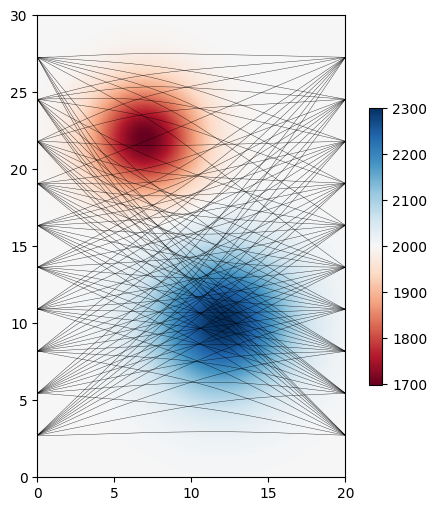

In [5]:
if(usepyfm2d):

    # set wavetracker options
    options = wt.WaveTrackerOptions(
        paths=True,
        cartesian=True,
        )
    smodel_good = fmm.good_model.reshape(fmm.model_shape) # retrieve slowness model
    vmodel_good = 1./smodel_good # retrieve velocity model

    result = wt.calc_wavefronts(vmodel_good,receivers,sources,extent=fmm.extent, options=options) # track wavefronts
    paths = result.paths

    wt.display_model(vmodel_good,paths=paths,extent=fmm.extent,line=0.3,alpha=0.82)

else: #Using geo-espresso forward model

    fmm.plot_model(fmm.good_model, with_paths=True); # espresso plot


Special to read in ttimes, sources and receivers from ascii file.

In [6]:
pprint.pprint(fmm.metadata)

{'author_names': ['Nick Rawlinson', 'Malcolm Sambridge'],
 'citations': [('Rawlinson, N., de Kool, M. and Sambridge, M., 2006. Seismic '
                'wavefront tracking in 3-D heterogeneous media: applications '
                'with multiple data classes, Explor. Geophys., 37, 322-330.',
                ''),
               ('Rawlinson, N. and Urvoy, M., 2006. Simultaneous inversion of '
                'active and passive source datasets for 3-D seismic structure '
                'with application to Tasmania, Geophys. Res. Lett., 33 L24313',
                '10.1029/2006GL028105'),
               ('de Kool, M., Rawlinson, N. and Sambridge, M. 2006. A '
                'practical grid based method for tracking multiple refraction '
                'and reflection phases in 3D heterogeneous media, Geophys. J. '
                'Int., 167, 253-270',
                ''),
               ('Saygin, E. 2007. Seismic receiver and noise correlation based '
                'studies in Aust

## 1. Problem setup and utilities

In [7]:
# get problem information from  espresso FmmTomography
model_size = fmm.model_size         # number of model parameters
model_shape = fmm.model_shape       # 2D spatial grids
data_size = fmm.data_size           # number of data points
ref_start_slowness = fmm.starting_model

In [8]:
def objective_func(slowness, sigma, reg):
    #ttimes = fmm.forward(slowness) # use geo-espresso forward model
    if(usepyfm2d):
        options = wt.WaveTrackerOptions(
            cartesian=True,
            )
        result = wt.calc_wavefronts(1./slowness.reshape(fmm.model_shape),receivers,sources,extent=fmm.extent,options=options) # track wavefronts
        ttimes = result.ttimes
    else:
        ttimes = fmm.forward(slowness)
    residual = obstimes - ttimes
    data_misfit = residual.T @ residual/sigma**2
    model_reg = reg(slowness)
    return data_misfit + model_reg

def gradient(slowness, sigma, reg):
    if(usepyfm2d):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(fmm.model_shape),receivers,sources,extent=fmm.extent,options=options) # track wavefronts
        ttimes = result.ttimes
        A = result.frechet.toarray()
    else:
        ttimes, A = fmm.forward(slowness, return_jacobian=True) # use geo-espresso forward model
    data_misfit_grad = -2 * A.T @ (obstimes - ttimes)/sigma**2
    model_reg_grad = reg.gradient(slowness)
    return data_misfit_grad + model_reg_grad

def hessian(slowness, sigma, reg):
    if(usepyfm2d):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(fmm.model_shape),receivers,sources,extent=fmm.extent,options=options)
        ttimes = result.ttimes
        A = result.frechet.toarray()
    else:
        A = fmm.jacobian(slowness) # use geo-espresso forward model  
    data_misfit_hess = 2 * A.T @ A/sigma**2
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

## 2. Invert with quadratic smoothing and damping regularization terms

### 2.1 Define BaseProblem

In [9]:
# define CoFI BaseProblem
fmm_problem_quadratic_reg = cofi.BaseProblem()
fmm_problem_quadratic_reg.set_initial_model(ref_start_slowness)

In [10]:
# add regularization: flattening + smoothing
smoothing_factor = 5e6
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_smoothing

In [11]:
sigma = 0.000008          # data standard deviation of noise
fmm_problem_quadratic_reg.set_objective(objective_func, args=[sigma, reg])
fmm_problem_quadratic_reg.set_gradient(gradient, args=[sigma, reg])
fmm_problem_quadratic_reg.set_hessian(hessian, args=[sigma, reg])

### 2.2 Define InversionOptions

In [12]:
my_options = cofi.InversionOptions()

my_options.set_tool("cofi.simple_newton")
my_options.set_params(
    num_iterations=15, 
    step_length=1, 
    obj_tol=1e-16,
    verbose=True, 
    hessian_is_symmetric=True
)

### 2.3 Start an inversion

In [13]:
inv = cofi.Inversion(fmm_problem_quadratic_reg, my_options)
inv_result_quadratic_reg = inv.run()
inv_result_quadratic_reg.summary()

Iteration #0, updated objective function value: 2983.3510758489483
Iteration #1, updated objective function value: 34.744456823253934
Iteration #2, updated objective function value: 3.6965798134506542
Iteration #3, updated objective function value: 0.40027231768010085
Iteration #4, updated objective function value: 0.7238436579445129
Iteration #5, updated objective function value: 0.24613946652490504
Iteration #6, updated objective function value: 0.5829402055736346
Iteration #7, updated objective function value: 0.1921014793867546
Iteration #8, updated objective function value: 0.4297219682282838
Iteration #9, updated objective function value: 0.17301245616627098
Iteration #10, updated objective function value: 0.3807360794888617
Iteration #11, updated objective function value: 0.15992903345544518
Iteration #12, updated objective function value: 0.3415362146683237
Iteration #13, updated objective function value: 0.15088746628372807
Iteration #14, updated objective function value: 0.32

Iteration #1, updated objective function value: 2.4528941433689466e-09


Iteration #2, updated objective function value: 1.6667499773269517e-10


Iteration #3, updated objective function value: 3.3183038228463554e-11


Iteration #4, updated objective function value: 3.8531578708747634e-11


Iteration #5, updated objective function value: 1.9386143575359088e-11


Iteration #6, updated objective function value: 3.2610301145716735e-11


Iteration #7, updated objective function value: 1.6209545072977018e-11


Iteration #8, updated objective function value: 2.8940439339590962e-11


Iteration #9, updated objective function value: 1.504739631713362e-11


Iteration #10, updated objective function value: 2.703178700016917e-11


Iteration #11, updated objective function value: 1.4195102480742004e-11


Iteration #12, updated objective function value: 2.5989058410062935e-11


Iteration #13, updated objective function value: 1.3980620229249818e-11


Iteration #14, updated objective function value: 2.5341981735230692e-11
Summary for inversion result
SUCCESS
----------------------------
model: [0.00050485 0.00049715 0.00048991 ... 0.00050558 0.00050199 0.00049801]
num_iterations: 14
objective_val: 2.5341981735230692e-11
n_obj_evaluations: 16
n_grad_evaluations: 15
n_hess_evaluations: 15


### 2.4 Plotting

In [14]:
# use geo-espresso plotting
#clim = (1/np.max(fmm.good_model)-1, 1/np.min(fmm.good_model)+1)
#fmm.plot_model(inv_result_quadratic_reg.model, clim=clim);            # inverted model
#fmm.plot_model(fmm.good_model);       # true model

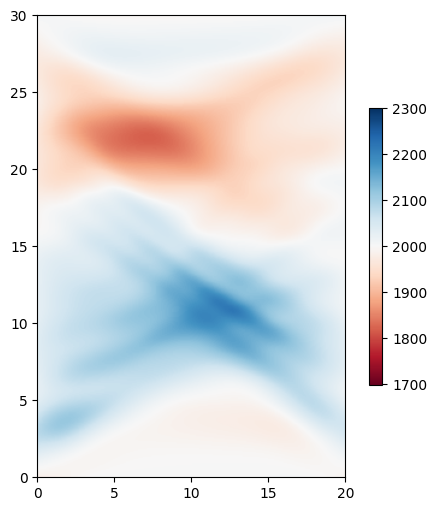

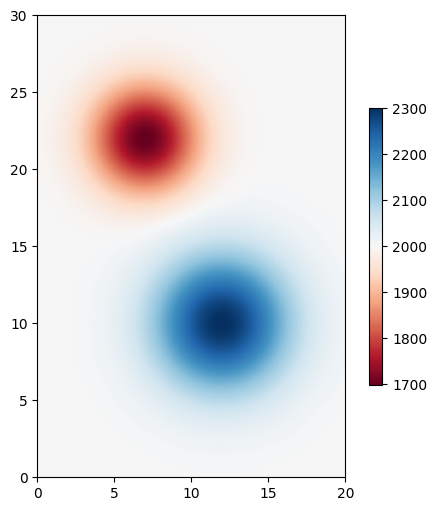

In [15]:
clim = (1/np.max(fmm.good_model)-1, 1/np.min(fmm.good_model)+1)

vmodel_inverted = 1./inv_result_quadratic_reg.model.reshape(fmm.model_shape)
wt.display_model(vmodel_inverted,extent=fmm.extent,clim=clim) # inverted model
wt.display_model(vmodel_good,extent=fmm.extent,clim=clim) # true model

---

## 3. Invert with Gaussian prior as regularization term

Instead of using a smoothing and damping regularization, in this section, we
use a model covariance matrix and prior model.

$\chi_{P}^{2}=\left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right)^T C_d^{-1} \left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right) + \left( \mathbf{m} - \mathbf{m}_p \right)^T C_p^{-1} \left( \mathbf{m} - \mathbf{m}_p \right)$

$\Delta \mathbf{m}= ({J}^T {C}_d^{-1} {J}+{C}_p^{-1})^{-1} ({J}^T{C}_d^{-1} (\mathbf{y}-\mathbf{f}(\mathbf{m}))+{C}_p^{-1}(\mathbf{m}_p-\mathbf{m}))$

We can use CoFI's utility module to help us generate a the Gaussian prior term.

### 3.1 Define BaseProblem

In [16]:
# define CoFI BaseProblem
fmm_problem_gaussian_prior = cofi.BaseProblem()
fmm_problem_gaussian_prior.set_initial_model(ref_start_slowness)

In [17]:
# add regularization: Gaussian prior
corrx = 3.0
corry = 3.0
sigma_slowness = 0.5**2
sigma_slowness = 2.5E-6
gaussian_prior = 0.01 * cofi.utils.GaussianPrior(
    model_covariance_inv=((corrx, corry), sigma_slowness),
    mean_model=ref_start_slowness.reshape(model_shape)
)

In [18]:
fmm_problem_gaussian_prior.set_objective(objective_func, args=[sigma,gaussian_prior])
fmm_problem_gaussian_prior.set_gradient(gradient, args=[sigma,gaussian_prior])
fmm_problem_gaussian_prior.set_hessian(hessian, args=[sigma,gaussian_prior])

### 3.2 Start an inversion

In [19]:
# reuse the previously defined InversionOptions object
inv = cofi.Inversion(fmm_problem_gaussian_prior, my_options)
inv_result_gaussian_prior = inv.run()
inv_result_gaussian_prior.summary()

Iteration #0, updated objective function value: 2366.2037106114262
Iteration #1, updated objective function value: 174.65570821925857
Iteration #2, updated objective function value: 35.82647750665292
Iteration #3, updated objective function value: 32.5782262844709
Iteration #4, updated objective function value: 32.737259743789735
Iteration #5, updated objective function value: 32.743534144170134
Iteration #6, updated objective function value: 32.98146845472718
Iteration #7, updated objective function value: 32.55230889142789
Iteration #8, updated objective function value: 32.95427277990427
Iteration #9, updated objective function value: 32.5622573584073
Iteration #10, updated objective function value: 32.96771640384137
Iteration #11, updated objective function value: 32.56582906727774
Iteration #12, updated objective function value: 32.97604132933526
Iteration #13, updated objective function value: 32.56760430605735
Iteration #14, updated objective function value: 32.992075449344554
Su

Iteration #1, updated objective function value: 2.350718903302728e-07


Iteration #2, updated objective function value: 2.3157837862854732e-07


Iteration #3, updated objective function value: 2.3147517909945304e-07


Iteration #4, updated objective function value: 2.3140410377488268e-07
Change in model parameters below tolerance, stopping.
Summary for inversion result
SUCCESS
----------------------------
model: [0.00049703 0.00049595 0.00049451 ... 0.000503   0.00050221 0.00050161]
num_iterations: 4
objective_val: 2.3140410377488268e-07
n_obj_evaluations: 6
n_grad_evaluations: 5
n_hess_evaluations: 5


### 3.3 Plotting

In [20]:
#fmm.plot_model(inv_result_gaussian_prior.model, clim=clim);            # gaussian prior
#fmm.plot_model(fmm.good_model);       # true model

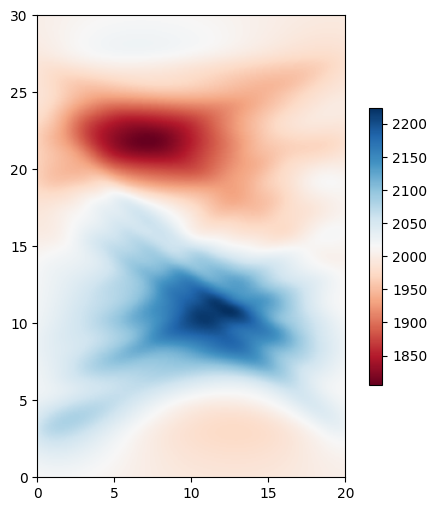

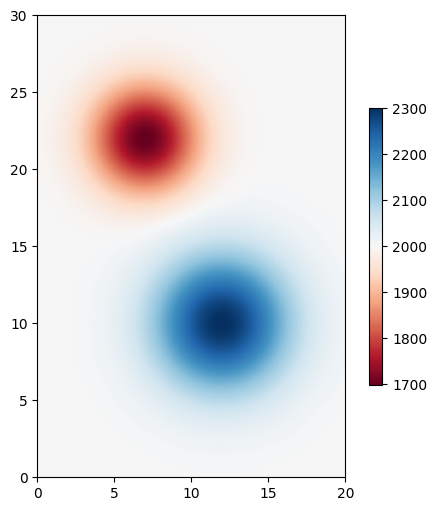

In [21]:
vmodel_inverted = 1./inv_result_gaussian_prior.model.reshape(fmm.model_shape)
#wt.display_model(vmodel_inverted,extent=fmm.extent,clim=clim) # inverted model
wt.display_model(vmodel_inverted,extent=fmm.extent) # inverted model
wt.display_model(vmodel_good,extent=fmm.extent,clim=clim) # true model

## 4. L-curve

Now we plot an L-curve for the smoothing regularization case.

In [22]:
lambdas = np.logspace(-4, 4, 10)

my_lcurve_problems = []
for lamb in lambdas:
    my_reg = lamb * reg_smoothing
    my_problem = cofi.BaseProblem()
    my_problem.set_objective(objective_func, args=[sigma,my_reg])
    my_problem.set_gradient(gradient, args=[sigma,my_reg])
    my_problem.set_hessian(hessian, args=[sigma,my_reg])
    my_problem.set_initial_model(ref_start_slowness)
    my_lcurve_problems.append(my_problem)

my_options.set_params(verbose=False)

def my_callback(inv_result, i):
    m = inv_result.model
    if(usepyfm2d):
        slowness=m
        options = wt.WaveTrackerOptions(
                cartesian=True,
                )
        result = wt.calc_wavefronts(1./slowness.reshape(fmm.model_shape),receivers,sources,extent=fmm.extent,options=options) # track wavefronts
        ttimes = result.ttimes
        res_norm = np.linalg.norm(ttimes - obstimes)/sigma**2
    else:
        res_norm = np.linalg.norm(fmm.forward(m) - obstimes)/sigma**2
    reg_norm = np.sqrt(reg_smoothing(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    my_lcurve_problems, 
    my_options, 
    my_callback, 
    False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=0.0001: 15973.482300303383, 1.1262218708577785
Finished inversion with lambda=0.000774263682681127: 15973.526628307027, 1.1261419404558382
Finished inversion with lambda=0.005994842503189409: 16085.775624418333, 1.1032860416030046
Finished inversion with lambda=0.046415888336127774: 3073.337842125626, 0.5174434845765434
Finished inversion with lambda=0.3593813663804626: 40097.0479875984, 0.2718748288631085
Finished inversion with lambda=2.782559402207126: 82636.51870963765, 0.21003009462691688
Finished inversion with lambda=21.54434690031882: 108183.97822756463, 0.18829420341926092
Finished inversion with lambda=166.81005372000558: 146395.99724069456, 0.16717054949674137
Finished inversion with lambda=1291.5496650148827: 327015.23938111606, 0.1325270376460823
Finished inversion with lambda=10000.0: 726098.4878090363, 0.1009439237039063


Finished inversion with lambda=0.0003727593720314938: 8.232290237790325e-08, 1.6409859691923215e-05

Finished inversion with lambda=0.0013894954943731374: 1.9905677794684863e-07, 1.505922872690565e-05

Finished inversion with lambda=10000.0: 7.06809917307888e-05, 1.2787492062591515e-06

Finished inversion with lambda=2682.695795279722: 4.3769121062239315e-05, 1.4854173593313605e-06

Finished inversion with lambda=0.005179474679231213: 3.567453205554154e-07, 1.1615033636531375e-05

Finished inversion with lambda=0.07196856730011514: 1.2538041385774708e-06, 3.889768196373246e-06

Finished inversion with lambda=0.019306977288832496: 3.644322816468502e-07, 6.184840917745463e-06

Finished inversion with lambda=0.2682695795279725: 3.685980157827899e-06, 3.169708881127217e-06

Finished inversion with lambda=1.0: 4.201876046449114e-06, 2.7724031859576007e-06

Finished inversion with lambda=3.727593720314938: 4.612444496061361e-06, 2.613419189036935e-06

Finished inversion with lambda=13.89495494373136: 5.600693836248979e-06, 2.476003384948556e-06

Finished inversion with lambda=51.79474679231202: 7.464829476033497e-06, 2.333899091119206e-06

Finished inversion with lambda=193.06977288832496: 1.2476292680582265e-05, 2.1078041141825236e-06

Finished inversion with lambda=719.6856730011514: 2.560668765694951e-05, 1.7667791266670531e-06

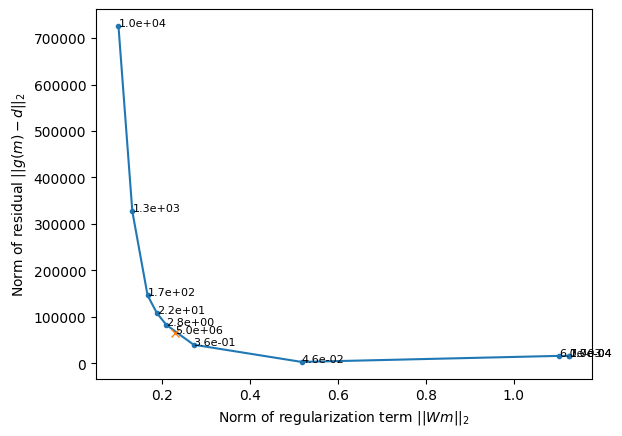

In [23]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(len(lambdas)):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

# plot the previously solved model
my_inverted_model = inv_result_quadratic_reg.model
my_reg_norm = np.sqrt(reg_smoothing(my_inverted_model))
if(usepyfm2d):
    slowness=my_inverted_model
    options = wt.WaveTrackerOptions(
            cartesian=True,
            )
    result = wt.calc_wavefronts(1./slowness.reshape(fmm.model_shape),receivers,sources,extent=fmm.extent,options=options) # track wavefronts
    ttimes = result.ttimes
    my_residual_norm = np.linalg.norm(ttimes - obstimes)/sigma**2
else:
    my_residual_norm = np.linalg.norm(fmm.forward(my_inverted_model) - obstimes)/sigma**2
plt.plot(my_reg_norm, my_residual_norm, "x")
plt.annotate(f"{smoothing_factor:.1e}", (my_reg_norm, my_residual_norm), fontsize=8);

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [27]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
espresso 0.4.0+2.g27389ac
numpy 2.2.3
matplotlib 3.10.1
